# Parsing CAM data (.json)

In [1]:
import json 
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
PATH = './sampleImg/'

In [3]:
with open(PATH+"liontiger.json") as json_file:
    json_data = json.load(json_file)

lion_data = np.array(json_data["lion"], dtype='uint8')
tiger_data = np.array(json_data["tiger"], dtype='uint8')

# heatmap 동작 확인

In [4]:
orig_heatmaps = []


img = cv2.imread(PATH+"lion_tiger.jpg")
height, width, _ = img.shape

# orig_heatmaps[0] = lion heatmap
orig_heatmaps.append(cv2.applyColorMap(cv2.resize(lion_data, (width, height)), cv2.COLORMAP_JET))
#result = orig_heatmaps[0] *0.7 + img + 0.5
#cv2.imshow(PATH+'lion_heatmap.jpg',result)

# orig_heatmaps[1] = tiger heatmap
orig_heatmaps.append(cv2.applyColorMap(cv2.resize(tiger_data, (width, height)), cv2.COLORMAP_JET))
#result = orig_heatmaps[1] *0.7 + img + 0.5
#cv2.imwrite(PATH+'tiger_heatmap.jpg',heatmap)

# color channel별 heatmap 뽑기

In [5]:
# orig_img에서 (R, G, B) 세 가지 채널의 정보 중 특정 채널의 정보만 남겨서 넘김
def getChannelImage(orig_img, channel):
    channel = channel.upper()
    channel_img = orig_img.copy()
    if channel == 'R':
        channel_img[:, :, 0] = 0
        channel_img[:, :, 1] = 0
    elif channel == 'G':
        channel_img[:, :, 0] = 0
        channel_img[:, :, 2] = 0
    elif channel == 'B':
        channel_img[:, :, 1] = 0
        channel_img[:, :, 2] = 0

    return channel_img

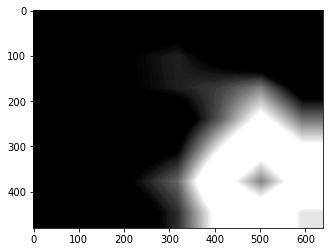

In [6]:
# orig_heatmap에서 `R` 계열이 가장 중요한 feature 부분을 나타내므로 해당 정보만 사용
heatmap = getChannelImage(orig_heatmaps[1], 'r')
# orig_heatmap의 R 채널 데이터를 gray scale로 출력
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY), cmap='gray')

# CAM 결과를 이용하여 Bounding Box 잡기

In [7]:
# color image를 gray scale로 바꾼 후, threshold를 적용함
def getGrayscaleImageWithThreshold(orig_img):
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    
    min_val = np.min(gray_img)
    max_val = np.max(gray_img)
    threshold = (min_val + max_val) / 2
    
    gray_img = np.where(gray_img > threshold, 1, 0)
    gray_img = gray_img.astype('int32')
    

    return gray_img

In [8]:
# grayscale_mask 에서 1인 부분만 orig_img를 보여줌. 0인 부분은 검정색으로 보임
def showMaskedRegion(orig_img, grayscale_mask):
    mask = cv2.cvtColor(np.float32(gray_map), cv2.COLOR_GRAY2BGR)
    
    maskedRegion = np.where(mask == 1, img, 0)
    plt.imshow(cv2.cvtColor(maskedRegion, cv2.COLOR_BGR2RGB))

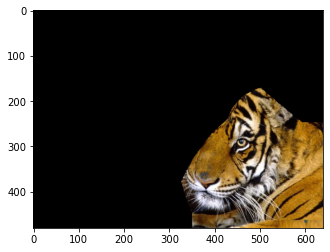

In [9]:
# gray scale img로 바꾸고, threshold 이상의 값만 binary로 살림
gray_map = getGrayscaleImageWithThreshold(heatmap)

showMaskedRegion(img, gray_map)